Epoch [10/100], Loss: 0.6887
Epoch [20/100], Loss: 0.6810
Epoch [30/100], Loss: 0.6734
Epoch [40/100], Loss: 0.6660
Epoch [50/100], Loss: 0.6587
Epoch [60/100], Loss: 0.6517
Epoch [70/100], Loss: 0.6448
Epoch [80/100], Loss: 0.6380
Epoch [90/100], Loss: 0.6315
Epoch [100/100], Loss: 0.6250
Logistic Regression Pixel-Wise Accuracy: 75.56%
SSVM Epoch [10/100], Loss: 0.8035
SSVM Epoch [20/100], Loss: 0.7869
SSVM Epoch [30/100], Loss: 0.7719
SSVM Epoch [40/100], Loss: 0.7584
SSVM Epoch [50/100], Loss: 0.7461
SSVM Epoch [60/100], Loss: 0.7348
SSVM Epoch [70/100], Loss: 0.7244
SSVM Epoch [80/100], Loss: 0.7147
SSVM Epoch [90/100], Loss: 0.7056
SSVM Epoch [100/100], Loss: 0.6970
Structured SVM Pixel-Wise Accuracy: 80.13%
Logistic Regression IoU: 0.2315
Structured SVM IoU: 0.2513


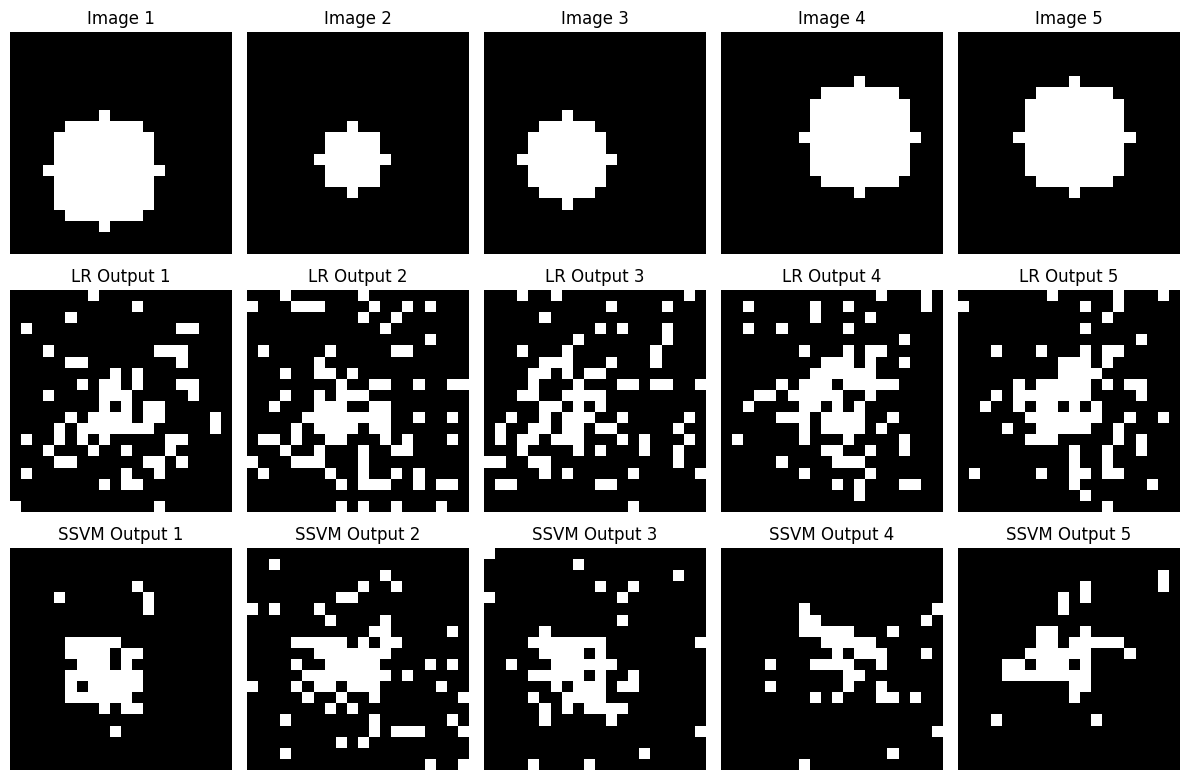

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Generation: Simulate Synthetic Image Segmentation Data

# Parameters for the synthetic image
image_size = 20  # 20x20 pixels
num_images = 100  # Generate 100 synthetic images
np.random.seed(42)

# Function to generate a synthetic image with a simple segmentation task (circle as foreground)
def generate_image(image_size, radius, center):
    y, x = np.ogrid[:image_size, :image_size]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    image = np.zeros((image_size, image_size), dtype=np.float32)
    image[mask] = 1.0
    return image

# Generate synthetic dataset
X_images = []
Y_labels = []
for _ in range(num_images):
    radius = np.random.randint(3, 6)
    center = np.random.randint(5, image_size - 5, size=2)
    X_images.append(generate_image(image_size, radius, center))
    Y_labels.append(center)  # We'll predict the center of the object for now

X_images = np.array(X_images)  # Shape (100, 20, 20)
Y_labels = np.array(Y_labels)  # Shape (100, 2)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_images, dtype=torch.float32).unsqueeze(1)  # Shape (100, 1, 20, 20)
y_tensor = torch.tensor(X_images, dtype=torch.float32).unsqueeze(1)  # Shape (100, 1, 20, 20)

# 2. Logistic Regression using PyTorch

class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(image_size * image_size, image_size * image_size)
        
    def forward(self, x):
        x = x.view(-1, image_size * image_size)  # Flatten the image
        out = self.linear(x)
        out = torch.sigmoid(out)
        out = out.view(-1, 1, image_size, image_size)  # Reshape to original image dimensions
        return out

# Instantiate the logistic regression model
log_reg_model = LogisticRegressionModel()

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(log_reg_model.parameters(), lr=0.1)

# Training the logistic regression model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = log_reg_model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Logistic Regression Prediction and Accuracy
with torch.no_grad():
    log_reg_pred = (log_reg_model(X_tensor) > 0.5).float()
    log_reg_accuracy = torch.mean((log_reg_pred == y_tensor).float())
    print(f"Logistic Regression Pixel-Wise Accuracy: {log_reg_accuracy.item() * 100:.2f}%")

# 3. Structured SVM-like Model with Pairwise Loss in PyTorch

class StructuredSVMModel(nn.Module):
    def __init__(self):
        super(StructuredSVMModel, self).__init__()
        self.linear = nn.Linear(image_size * image_size, image_size * image_size)
    
    def forward(self, x):
        x = x.view(-1, image_size * image_size)  # Flatten the image
        out = self.linear(x)
        out = torch.sigmoid(out)
        out = out.view(-1, 1, image_size, image_size)  # Reshape to original image dimensions
        return out
    
    # Custom loss function incorporating pairwise interaction
    def structured_loss(self, pred, target):
        pixel_loss = criterion(pred, target)  # Pixel-wise loss

        # Compute pairwise loss using shifts (more efficient)
        pred_shift_right = pred[:, :, :, 1:]
        pred_current = pred[:, :, :, :-1]
        loss_right = torch.sum(torch.abs(pred_current - pred_shift_right))

        pred_shift_down = pred[:, :, 1:, :]
        pred_current = pred[:, :, :-1, :]
        loss_down = torch.sum(torch.abs(pred_current - pred_shift_down))

        pairwise_loss = loss_right + loss_down

        total_loss = pixel_loss + pairwise_loss / (pred.numel())
        return total_loss

# Instantiate the structured SVM-like model
ssvm_model = StructuredSVMModel()

# Optimizer
optimizer_ssvm = optim.SGD(ssvm_model.parameters(), lr=0.1)

# Training the structured SVM-like model
for epoch in range(num_epochs):
    optimizer_ssvm.zero_grad()
    
    # Forward pass
    ssvm_outputs = ssvm_model(X_tensor)
    
    # Custom structured loss
    loss_ssvm = ssvm_model.structured_loss(ssvm_outputs, y_tensor)
    
    # Backward and optimize
    loss_ssvm.backward()
    optimizer_ssvm.step()

    if (epoch+1) % 10 == 0:
        print(f'SSVM Epoch [{epoch+1}/{num_epochs}], Loss: {loss_ssvm.item():.4f}')

# Structured SVM Prediction and Accuracy
with torch.no_grad():
    ssvm_pred = (ssvm_model(X_tensor) > 0.5).float()
    ssvm_accuracy = torch.mean((ssvm_pred == y_tensor).float())
    print(f"Structured SVM Pixel-Wise Accuracy: {ssvm_accuracy.item() * 100:.2f}%")

# 4. IoU (Intersection over Union) Metric for Segmentation

def iou_score(pred, target):
    pred = pred.view(-1).cpu().numpy()
    target = target.view(-1).cpu().numpy()
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    if np.sum(union) == 0:
        return 1.0  # Avoid division by zero
    iou = np.sum(intersection) / np.sum(union)
    return iou

log_reg_iou = iou_score(log_reg_pred, y_tensor)
ssvm_iou = iou_score(ssvm_pred, y_tensor)

print(f"Logistic Regression IoU: {log_reg_iou:.4f}")
print(f"Structured SVM IoU: {ssvm_iou:.4f}")

# 5. Visualize Segmentation Results

# Visualize results from Logistic Regression and Structured SVM
plt.figure(figsize=(12, 8))
for i in range(5):
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis("off")
    
    # Logistic Regression output
    plt.subplot(3, 5, i + 6)
    plt.imshow(log_reg_pred[i, 0], cmap='gray')
    plt.title(f"LR Output {i+1}")
    plt.axis("off")
    
    # Structured SVM output
    plt.subplot(3, 5, i + 11)
    plt.imshow(ssvm_pred[i, 0], cmap='gray')
    plt.title(f"SSVM Output {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()